---
# <center>Dataset creation

In [8]:
import os
import torchaudio

# Set the audio backend explicitly
torchaudio.set_audio_backend("sox_io")

# Rest of your imports and code...
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
from torchinfo import summary

#################################
# Dataset and Data Preparation  #
#################################

class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None, root="./datasets/speechcommand", download=True):
        # Ensure that the root directory exists before initializing the dataset
        os.makedirs(root, exist_ok=True)
        super().__init__(root=root, download=download)
        
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.join(self._path, line.strip()) for line in f]
        
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

class InMemorySpeechCommands(Dataset):
    def __init__(self, subset="training", fixed_length=16000):
        self.fixed_length = fixed_length
        self.dataset = SubsetSC(subset=subset, root="./datasets/speechcommand", download=True)
        self.data = []
        self.labels = []
        
        dataset_root = self.dataset._path  # use the path used by the dataset
        all_labels = [
            d for d in os.listdir(dataset_root)
            if os.path.isdir(os.path.join(dataset_root, d)) and d != '_background_noise_'
        ]
        self.label_set = sorted(all_labels)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.label_set)}
        print(f"Found {len(self.label_set)} labels: {self.label_set}")
        
        # load all samples into memory (resample, pad/trim)
        for waveform, sample_rate, label, *_ in tqdm(self.dataset, desc=f"Loading {subset} data", leave=False):
            if sample_rate != 16000:
                resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
                waveform = resampler(waveform)
            waveform = waveform.squeeze(0)  # remove channel dimension if exists
            if waveform.size(0) > fixed_length:
                waveform = waveform[:fixed_length]
            elif waveform.size(0) < fixed_length:
                waveform = torch.nn.functional.pad(waveform, (0, fixed_length - waveform.size(0)))
            self.data.append(waveform)
            try:
                self.labels.append(self.label_to_idx[label])
            except KeyError:
                # if a label is encountered that's not in our mapping, add it
                new_idx = len(self.label_to_idx)
                print(f"New label found: {label}. Assigning new index {new_idx}")
                self.label_to_idx[label] = new_idx
                self.label_set.append(label)
                self.labels.append(new_idx)
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.fixed_length, self.labels[idx]


/var/folders/3t/9pfjmtv5277d5j2y93gvpb6m0000gn/T/ipykernel_88545/3054675651.py:5: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [6]:
import os
import pickle


def get_dataset(subset, fixed_length=16000, pickle_path=None):
    if pickle_path is None:
        pickle_path = f"./datasets/{subset}_dataset.pkl"
    
    if os.path.exists(pickle_path):
        print(f"Loading {subset} dataset from pickle file...")
        with open(pickle_path, "rb") as f:
            dataset = pickle.load(f)
    else:
        print(f"Creating {subset} dataset and saving to pickle...")
        # Replace InMemorySpeechCommands with your actual dataset creation call
        dataset = InMemorySpeechCommands(subset=subset, fixed_length=fixed_length)
        os.makedirs(os.path.dirname(pickle_path), exist_ok=True)
        with open(pickle_path, "wb") as f:
            pickle.dump(dataset, f)
    
    return dataset


# train_dataset = get_dataset("training", fixed_length=16000)
# val_dataset = get_dataset("validation", fixed_length=16000)
test_dataset = get_dataset(subset = "test", fixed_length=16000)

num_classes = len(test_dataset.label_set)


Loading test dataset from pickle file...


---
# <center>Model Architecture

In [14]:
from model import EncDecClassificationModel

model = EncDecClassificationModel(num_classes=num_classes, sample_rate=16000)

summary(model, input_data=(torch.randn(1, 16000) , torch.tensor([16000])))

Layer (type:depth-idx)                             Output Shape              Param #
EncDecClassificationModel                          [1, 35]                   --
├─AudioToMFCCPreprocessor: 1-1                     [1, 64, 101]              --
│    └─MFCC: 2-1                                   [1, 64, 101]              --
│    │    └─MelSpectrogram: 3-1                    [1, 64, 101]              --
│    │    └─AmplitudeToDB: 3-2                     [1, 64, 101]              --
├─ConvASREncoder: 1-2                              [1, 128, 101]             --
│    └─Sequential: 2-2                             --                        --
│    │    └─JasperBlock: 3-3                       [1, 128, 101]             9,152
│    │    └─JasperBlock: 3-4                       [1, 64, 101]              18,304
│    │    └─JasperBlock: 3-5                       [1, 64, 101]              9,408
│    │    └─JasperBlock: 3-6                       [1, 64, 101]              9,536
│    │    └─JasperBloc

---
# <center>Training

Checkpoint saved to checkpoints/classification_experiment/checkpoint_0_1654_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.2898 and val acc: 91.44%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_0_1654.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [1/50] Train Loss: 0.6865 | Train Acc: 81.17% | Val Loss: 0.2898 | Val Acc: 91.44%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_1_3308_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.2180 and val acc: 93.50%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_1_3308.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [2/50] Train Loss: 0.2950 | Train Acc: 91.21% | Val Loss: 0.2180 | Val Acc: 93.50%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_2_4962_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1740 and val acc: 94.59%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_2_4962.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [3/50] Train Loss: 0.2428 | Train Acc: 92.68% | Val Loss: 0.1740 | Val Acc: 94.59%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_3_6616_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1555 and val acc: 94.97%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_3_6616.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [4/50] Train Loss: 0.2118 | Train Acc: 93.53% | Val Loss: 0.1555 | Val Acc: 94.97%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_4_8270_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1433 and val acc: 95.44%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_4_8270.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [5/50] Train Loss: 0.1895 | Train Acc: 94.18% | Val Loss: 0.1433 | Val Acc: 95.44%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_5_9924_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1291 and val acc: 95.85%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_5_9924.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [6/50] Train Loss: 0.1729 | Train Acc: 94.70% | Val Loss: 0.1291 | Val Acc: 95.85%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_6_11578_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.1097 and val acc: 96.82%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_6_11578.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [7/50] Train Loss: 0.1600 | Train Acc: 95.01% | Val Loss: 0.1097 | Val Acc: 96.82%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_7_13232_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0931 and val acc: 97.04%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_7_13232.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [8/50] Train Loss: 0.1475 | Train Acc: 95.37% | Val Loss: 0.0931 | Val Acc: 97.04%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_8_14886.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [9/50] Train Loss: 0.1384 | Train Acc: 95.64% | Val Loss: 0.0989 | Val Acc: 97.03%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_9_16540_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0859 and val acc: 97.21%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_9_16540.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [10/50] Train Loss: 0.1301 | Train Acc: 95.88% | Val Loss: 0.0859 | Val Acc: 97.21%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_10_18194_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0817 and val acc: 97.30%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_10_18194.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [11/50] Train Loss: 0.1242 | Train Acc: 96.06% | Val Loss: 0.0817 | Val Acc: 97.30%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_11_19848_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0755 and val acc: 97.50%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_11_19848.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [12/50] Train Loss: 0.1157 | Train Acc: 96.35% | Val Loss: 0.0755 | Val Acc: 97.50%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_12_21502_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0658 and val acc: 97.85%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_12_21502.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [13/50] Train Loss: 0.1098 | Train Acc: 96.48% | Val Loss: 0.0658 | Val Acc: 97.85%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_13_23156.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [14/50] Train Loss: 0.1044 | Train Acc: 96.70% | Val Loss: 0.0669 | Val Acc: 97.76%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_14_24810_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0617 and val acc: 98.04%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_14_24810.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [15/50] Train Loss: 0.0989 | Train Acc: 96.86% | Val Loss: 0.0617 | Val Acc: 98.04%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_15_26464_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0579 and val acc: 98.18%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_15_26464.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [16/50] Train Loss: 0.0959 | Train Acc: 96.91% | Val Loss: 0.0579 | Val Acc: 98.18%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_16_28118_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0531 and val acc: 98.31%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_16_28118.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [17/50] Train Loss: 0.0902 | Train Acc: 97.11% | Val Loss: 0.0531 | Val Acc: 98.31%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_17_29772.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [18/50] Train Loss: 0.0849 | Train Acc: 97.25% | Val Loss: 0.0538 | Val Acc: 98.30%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_18_31426.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [19/50] Train Loss: 0.0830 | Train Acc: 97.33% | Val Loss: 0.0540 | Val Acc: 98.24%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_19_33080_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0506 and val acc: 98.40%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_19_33080.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [20/50] Train Loss: 0.0810 | Train Acc: 97.41% | Val Loss: 0.0506 | Val Acc: 98.40%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_20_34734.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [21/50] Train Loss: 0.0765 | Train Acc: 97.57% | Val Loss: 0.0569 | Val Acc: 98.20%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_21_36388_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0442 and val acc: 98.55%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_21_36388.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [22/50] Train Loss: 0.0759 | Train Acc: 97.57% | Val Loss: 0.0442 | Val Acc: 98.55%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_22_38042_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0411 and val acc: 98.71%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_22_38042.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [23/50] Train Loss: 0.0710 | Train Acc: 97.73% | Val Loss: 0.0411 | Val Acc: 98.71%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_23_39696.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [24/50] Train Loss: 0.0697 | Train Acc: 97.79% | Val Loss: 0.0460 | Val Acc: 98.60%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_24_41350_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0354 and val acc: 98.87%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_24_41350.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [25/50] Train Loss: 0.0670 | Train Acc: 97.92% | Val Loss: 0.0354 | Val Acc: 98.87%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_25_43004.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [26/50] Train Loss: 0.0644 | Train Acc: 97.97% | Val Loss: 0.0366 | Val Acc: 98.78%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_26_44658.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [27/50] Train Loss: 0.0639 | Train Acc: 97.96% | Val Loss: 0.0384 | Val Acc: 98.76%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_27_46312.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [28/50] Train Loss: 0.0614 | Train Acc: 98.06% | Val Loss: 0.0374 | Val Acc: 98.78%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_28_47966.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [29/50] Train Loss: 0.0616 | Train Acc: 98.06% | Val Loss: 0.0410 | Val Acc: 98.64%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_29_49620_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0331 and val acc: 98.97%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_29_49620.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [30/50] Train Loss: 0.0570 | Train Acc: 98.22% | Val Loss: 0.0331 | Val Acc: 98.97%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_30_51274_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0305 and val acc: 99.02%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_30_51274.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [31/50] Train Loss: 0.0573 | Train Acc: 98.18% | Val Loss: 0.0305 | Val Acc: 99.02%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_31_52928_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0270 and val acc: 99.17%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_31_52928.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [32/50] Train Loss: 0.0567 | Train Acc: 98.18% | Val Loss: 0.0270 | Val Acc: 99.17%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_32_54582_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0270 and val acc: 99.25%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_32_54582.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [33/50] Train Loss: 0.0516 | Train Acc: 98.38% | Val Loss: 0.0270 | Val Acc: 99.25%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_33_56236.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [34/50] Train Loss: 0.0541 | Train Acc: 98.26% | Val Loss: 0.0304 | Val Acc: 99.02%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_34_57890.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [35/50] Train Loss: 0.0487 | Train Acc: 98.48% | Val Loss: 0.0343 | Val Acc: 98.81%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_35_59544_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0247 and val acc: 99.21%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_35_59544.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [36/50] Train Loss: 0.0507 | Train Acc: 98.39% | Val Loss: 0.0247 | Val Acc: 99.21%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_36_61198.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [37/50] Train Loss: 0.0502 | Train Acc: 98.43% | Val Loss: 0.0272 | Val Acc: 99.22%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_37_62852.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [38/50] Train Loss: 0.0466 | Train Acc: 98.53% | Val Loss: 0.0273 | Val Acc: 99.13%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_38_64506.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [39/50] Train Loss: 0.0465 | Train Acc: 98.54% | Val Loss: 0.0259 | Val Acc: 99.19%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_39_66160_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0203 and val acc: 99.39%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_39_66160.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [40/50] Train Loss: 0.0465 | Train Acc: 98.51% | Val Loss: 0.0203 | Val Acc: 99.39%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_40_67814.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [41/50] Train Loss: 0.0433 | Train Acc: 98.61% | Val Loss: 0.0215 | Val Acc: 99.35%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_41_69468.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [42/50] Train Loss: 0.0446 | Train Acc: 98.59% | Val Loss: 0.0277 | Val Acc: 99.13%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_42_71122.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [43/50] Train Loss: 0.0426 | Train Acc: 98.67% | Val Loss: 0.0213 | Val Acc: 99.33%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_43_72776_best.pt
Step history saved to checkpoints/classification_experiment/step_history.json
New best model saved with val loss: 0.0184 and val acc: 99.44%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_43_72776.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [44/50] Train Loss: 0.0404 | Train Acc: 98.76% | Val Loss: 0.0184 | Val Acc: 99.44%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_44_74430.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [45/50] Train Loss: 0.0430 | Train Acc: 98.66% | Val Loss: 0.0222 | Val Acc: 99.34%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_45_76084.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [46/50] Train Loss: 0.0386 | Train Acc: 98.82% | Val Loss: 0.0240 | Val Acc: 99.41%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_46_77738.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [47/50] Train Loss: 0.0391 | Train Acc: 98.80% | Val Loss: 0.0215 | Val Acc: 99.31%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_47_79392.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [48/50] Train Loss: 0.0371 | Train Acc: 98.80% | Val Loss: 0.0204 | Val Acc: 99.37%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_48_81046.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [49/50] Train Loss: 0.0368 | Train Acc: 98.84% | Val Loss: 0.0191 | Val Acc: 99.42%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_49_82700.pt
Step history saved to checkpoints/classification_experiment/step_history.json
Epoch [50/50] Train Loss: 0.0371 | Train Acc: 98.81% | Val Loss: 0.0242 | Val Acc: 99.28%


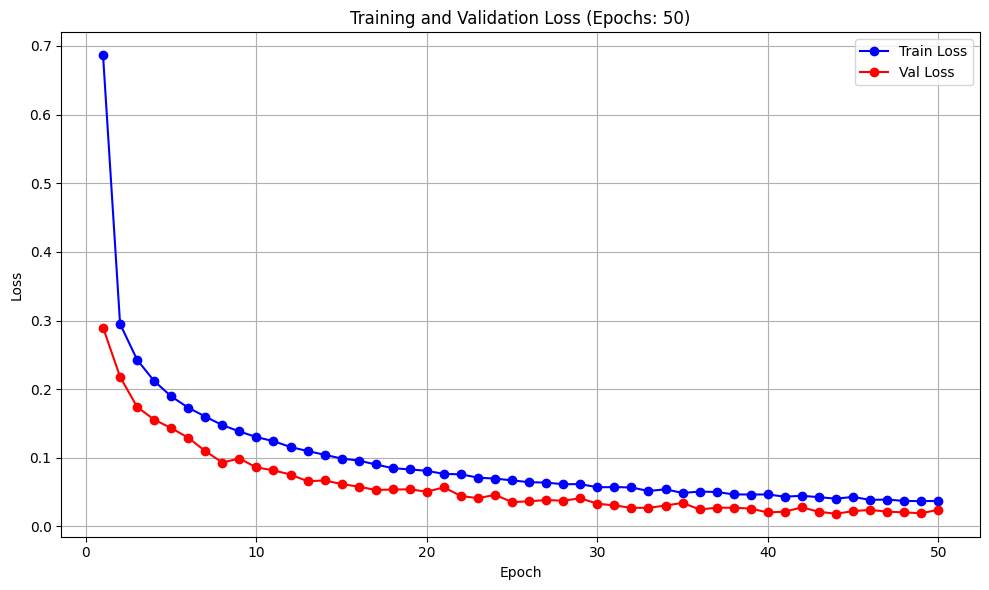

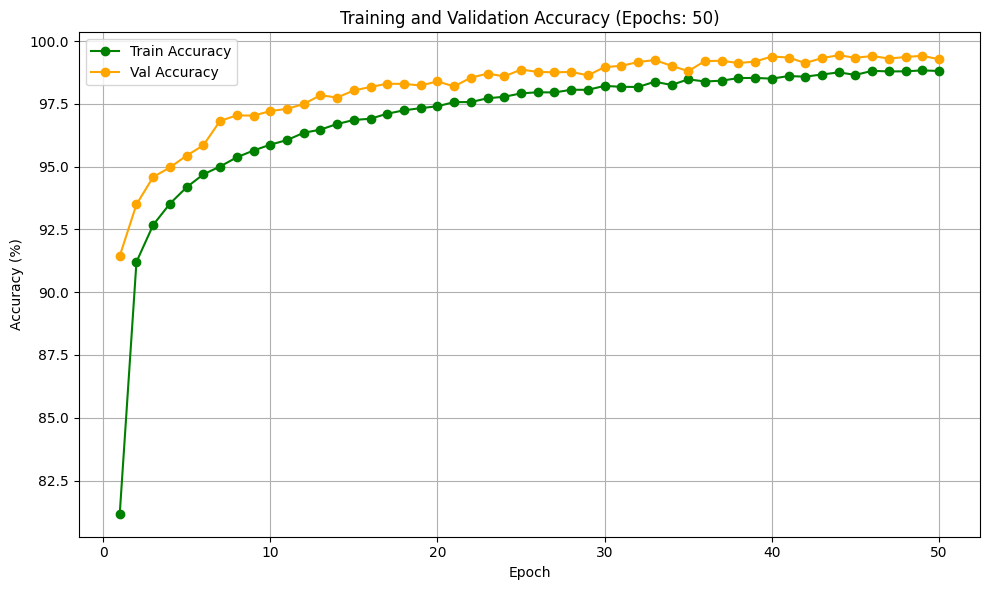

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from training_utils import run_training_classification

# Configuration
experiment_name = "classification_experiment"
num_epochs = 50
batch_size = 64
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_losses, train_accuracies, val_losses, val_accuracies, step_history = run_training_classification(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer_class=optim.Adam,
    optimizer_params={'lr': learning_rate},
    scheduler_class=optim.lr_scheduler.ReduceLROnPlateau,  # use a scheduler if needed
    scheduler_params={'mode': 'min', 'factor': 0.5, 'patience': 5},
    num_epochs=num_epochs,
    device=device,
    batch_size=batch_size,
    num_workers=4,
    resume_training=False,
    experiment_name=experiment_name,
    checkpoint_frequency=None  # set to None to save only once per epoch
)

history = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "step_history": step_history
}
with open(f"checkpoints/{experiment_name}/training_history.json", "w") as f:
    json.dump(history, f, indent=4)

# --- Plotting the Metrics ---

# Plot loss curves (per epoch)
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss (Epochs: {num_epochs})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy curves (per epoch)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green', marker='o')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training and Validation Accuracy (Epochs: {num_epochs})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate_model(model, test_dataset, device, batch_size=64, num_workers=4):
    """
    Evaluate the model on the test dataset.
    
    Returns:
        overall_accuracy (float): Overall test accuracy in percentage.
        all_preds (list): List of predicted class indices.
        all_targets (list): List of true class indices.
    """
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval()
    
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, fixed_length, labels in tqdm(test_loader, desc="Evaluating"):
            data = data.to(device)
            labels = labels.to(device)
            # If fixed_length is a tensor (or a list), extract the first value
            if isinstance(fixed_length, torch.Tensor):
                fixed_length_val = int(fixed_length[0].item())
            else:
                fixed_length_val = fixed_length
            
            # Create a tensor of lengths for the batch
            lengths = torch.full((data.size(0),), fixed_length_val, dtype=torch.long, device=device)
            logits = model(data, lengths)
            preds = torch.argmax(logits, dim=-1)
            
            total_correct += (preds == labels).sum().item()
            total_samples += data.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    overall_accuracy = total_correct / total_samples * 100
    return overall_accuracy, all_preds, all_targets

# Evaluate the model on the test dataset
test_accuracy, all_preds, all_targets = evaluate_model(model, test_dataset, device=device)
print(f"Test Accuracy: {test_accuracy:.2f}%")


# --- Plotting the results ---

# 1. Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
labels = test_dataset.label_set  # list of label names in sorted order

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Classification Report (printed)
report = classification_report(all_targets, all_preds, target_names=labels)
print("Classification Report:\n", report)

# 3. Per-Class Accuracy Bar Chart
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
per_class_accuracy = np.diag(cm_normalized) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=per_class_accuracy, palette="viridis")
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.ylim(90, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'device' is not defined

----
# <center> MIT model

Dummy input shape for FLOPs estimation: torch.Size([1, 128, 128])
Hugging Face Model FLOPs: 12.44 GMac, Params: 85.4 M


Evaluating HF Model: 100%|██████████| 172/172 [00:24<00:00,  6.90it/s]


Hugging Face Model Test Accuracy: 98.03%
Inference Timing Info (HF Model):
  total_inference_time_sec: 17.636587
  avg_batch_time_sec: 0.102538
  avg_sample_time_sec: 0.001603
  num_samples: 11005


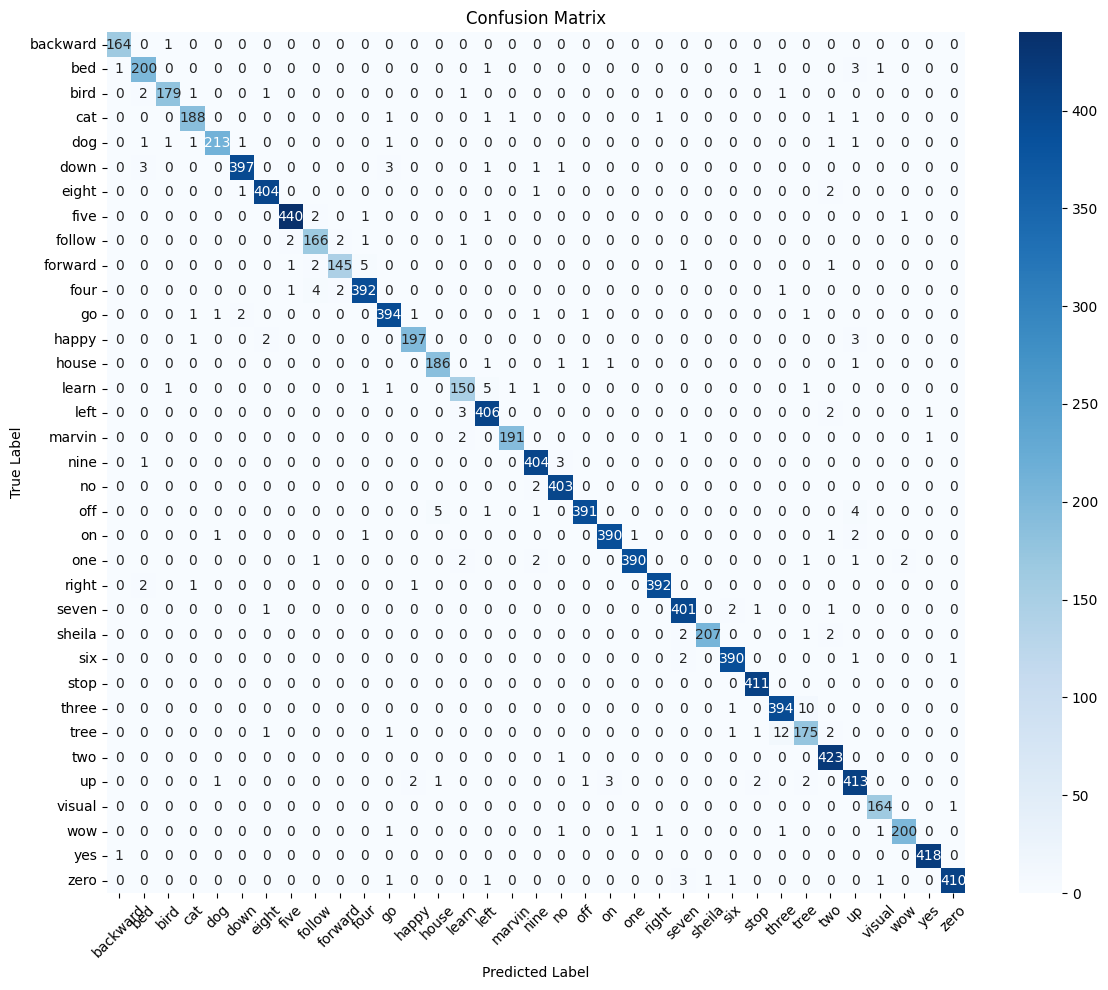

Classification Report (HF Model):
               precision    recall  f1-score   support

    backward       0.99      0.99      0.99       165
         bed       0.96      0.97      0.96       207
        bird       0.98      0.97      0.98       185
         cat       0.97      0.97      0.97       194
         dog       0.99      0.97      0.98       220
        down       0.99      0.98      0.98       406
       eight       0.99      0.99      0.99       408
        five       0.99      0.99      0.99       445
      follow       0.95      0.97      0.96       172
     forward       0.97      0.94      0.95       155
        four       0.98      0.98      0.98       400
          go       0.98      0.98      0.98       402
       happy       0.98      0.97      0.98       203
       house       0.97      0.97      0.97       191
       learn       0.94      0.93      0.94       161
        left       0.97      0.99      0.98       412
      marvin       0.99      0.98      0.98   

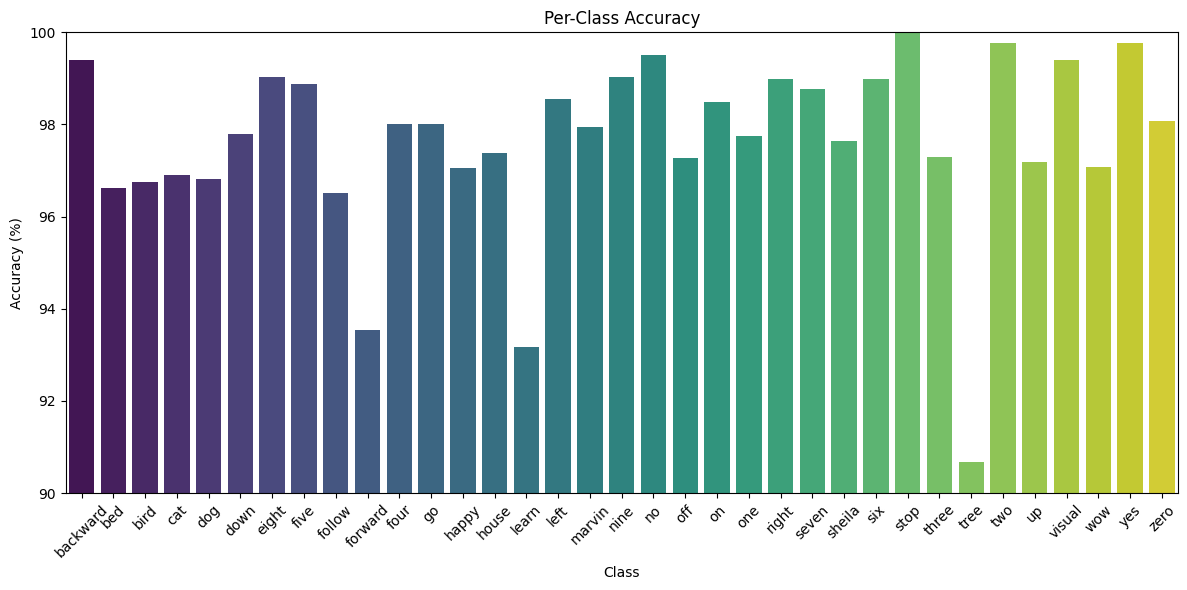

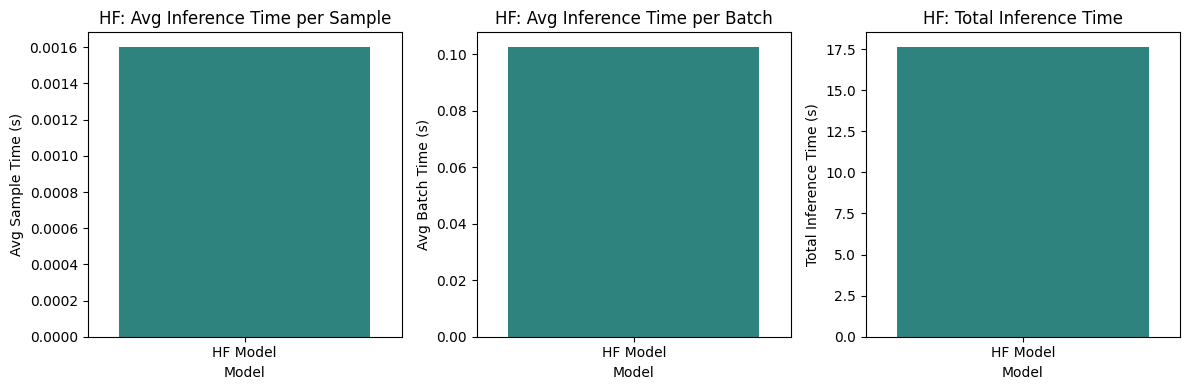

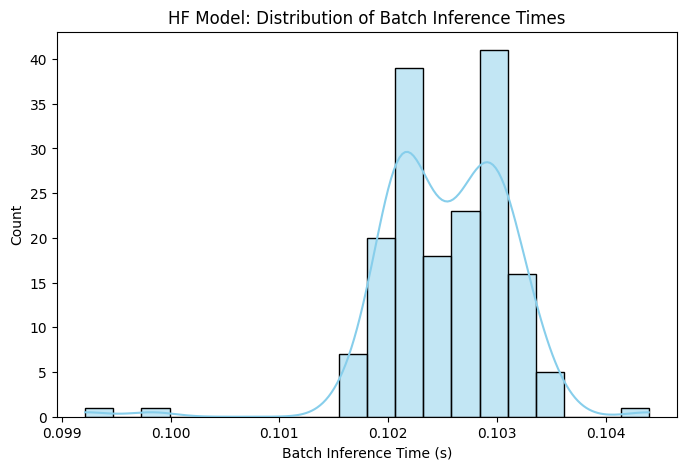

Evaluating Custom Model: 100%|██████████| 172/172 [00:01<00:00, 111.69it/s]


Custom Model Test Accuracy: 99.26%
Inference Timing Info (Custom Model):
  total_inference_time_sec: 0.470326
  avg_batch_time_sec: 0.002734
  avg_sample_time_sec: 0.000043
  num_samples: 11005


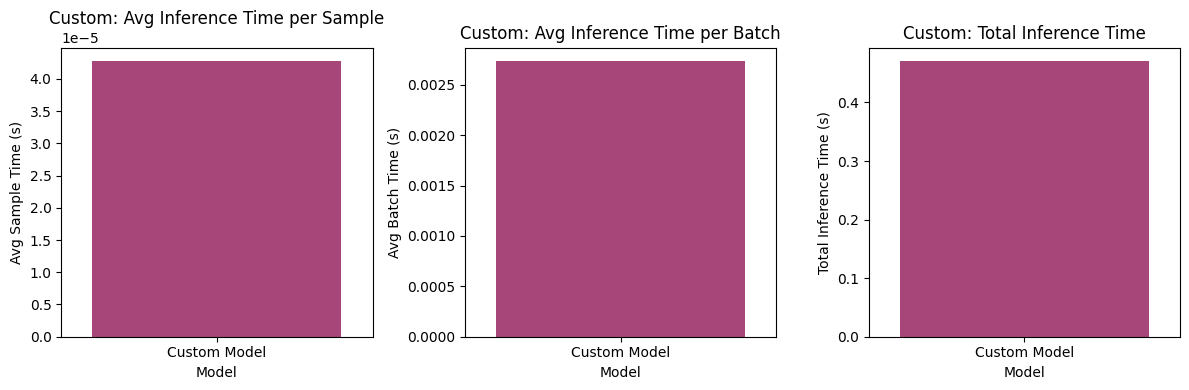

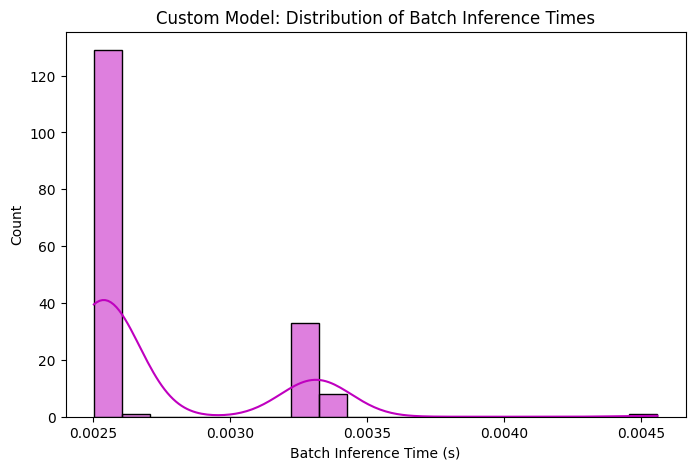

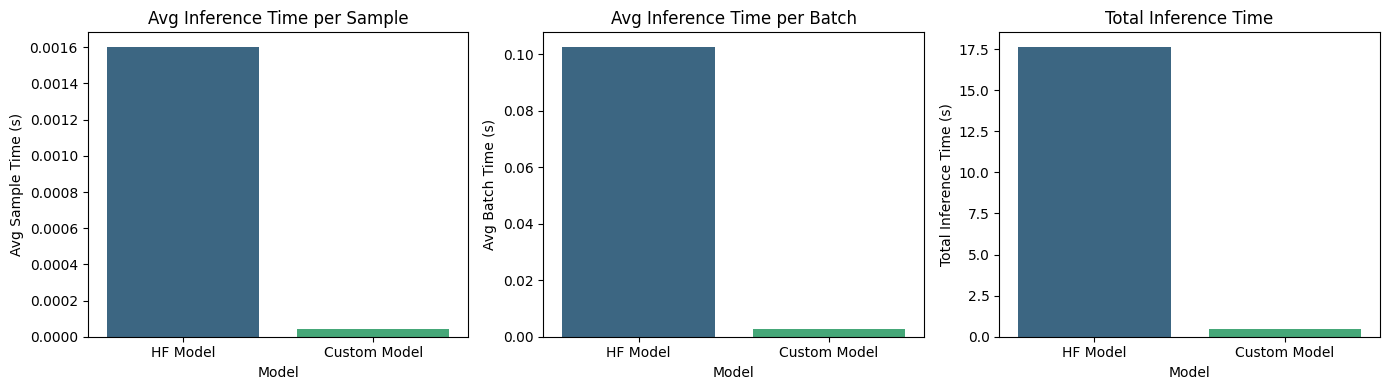

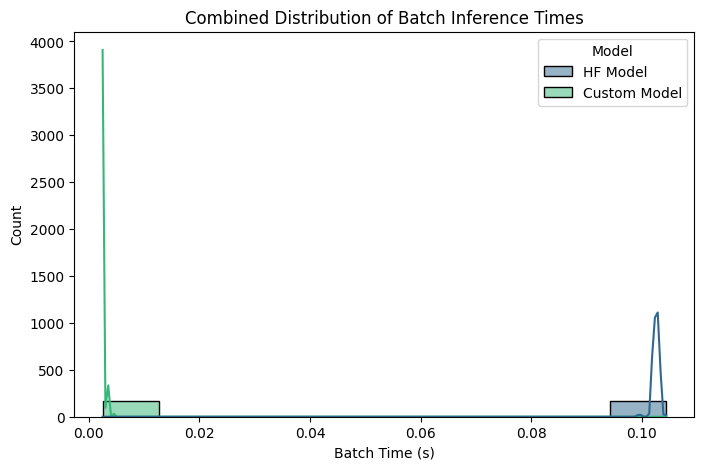

In [ ]:
import time
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Import the Hugging Face classes
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

# (Optional) Compute FLOPs if ptflops is installed:
try:
    from ptflops import get_model_complexity_info
except ImportError:
    get_model_complexity_info = None

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Load Hugging Face Model
# ------------------------------
hf_model_name = "MIT/ast-finetuned-speech-commands-v2"
feature_extractor = AutoFeatureExtractor.from_pretrained(hf_model_name)
hf_model = AutoModelForAudioClassification.from_pretrained(hf_model_name)
hf_model.to(device)
hf_model.eval()
summary(hf_model, (1, 16000))

In [ ]:

# ------------------------------
# Evaluation function for HF model
# ------------------------------
def evaluate_hf_model(model, feature_extractor, test_dataset, device, batch_size=64, num_workers=4):
    """
    Evaluate a Hugging Face model on the test dataset and measure inference timings.
    
    Returns:
        overall_accuracy (float): Overall test accuracy in percentage.
        all_preds (list): List of predicted class indices (remapped to match test dataset labels).
        all_targets (list): List of true class indices.
        timing_info (dict): Dictionary with timing metrics and batch times.
    """
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Get the HF model's label mapping (keys might be ints or strings)
    hf_id2label = model.config.id2label
    key_type = type(list(hf_id2label.keys())[0])
    
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    batch_inference_times = []  # seconds per batch
    use_cuda_timing = device.type == 'cuda'
    
    with torch.no_grad():
        for data, fixed_length, labels in tqdm(test_loader, desc="Evaluating HF Model"):
            # Convert each waveform to numpy array
            audio_samples = [waveform.cpu().numpy() for waveform in data]
            inputs = feature_extractor(audio_samples, sampling_rate=16000, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Timing start
            if use_cuda_timing:
                torch.cuda.synchronize()
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
                start_event.record()
            else:
                start_time = time.time()
            
            outputs = model(**inputs)
            
            # Timing end
            if use_cuda_timing:
                end_event.record()
                torch.cuda.synchronize()
                batch_time = start_event.elapsed_time(end_event) / 1000.0  # convert ms to s
            else:
                end_time = time.time()
                batch_time = end_time - start_time
            batch_inference_times.append(batch_time)
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            
            # Remap predictions using the HF model's label mapping.
            remapped_preds = []
            for pred in preds.cpu().numpy():
                if key_type is int:
                    hf_label = hf_id2label[pred]
                else:
                    hf_label = hf_id2label[str(pred)]
                try:
                    remapped_idx = test_dataset.label_set.index(hf_label)
                except ValueError:
                    print(f"Warning: label '{hf_label}' not found in test dataset labels.")
                    remapped_idx = -1
                remapped_preds.append(remapped_idx)
            
            labels = labels.to(device)
            total_correct += (torch.tensor(remapped_preds, device=device) == labels).sum().item()
            total_samples += data.size(0)
            
            all_preds.extend(remapped_preds)
            all_targets.extend(labels.cpu().numpy())
    
    overall_accuracy = total_correct / total_samples * 100
    total_inference_time = sum(batch_inference_times)
    avg_batch_time = np.mean(batch_inference_times)
    avg_sample_time = total_inference_time / total_samples
    
    timing_info = {
        "total_inference_time_sec": total_inference_time,
        "avg_batch_time_sec": avg_batch_time,
        "avg_sample_time_sec": avg_sample_time,
        "num_samples": total_samples,
        "batch_times": batch_inference_times
    }
    
    return overall_accuracy, all_preds, all_targets, timing_info

# ------------------------------
# (Optional) Compute FLOPs for HF model if ptflops is installed
# ------------------------------
if get_model_complexity_info is not None:
    dummy_waveform = np.zeros(16000, dtype=np.float32)
    inputs = feature_extractor([dummy_waveform], sampling_rate=16000, return_tensors="pt", padding=True)
    dummy_input = inputs["input_values"]
    print("Dummy input shape for FLOPs estimation:", dummy_input.shape)
    input_res = tuple(dummy_input.shape[1:])
    macs, params = get_model_complexity_info(hf_model, input_res, as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f"Hugging Face Model FLOPs: {macs}, Params: {params}")

# ------------------------------
# Evaluate HF model on test dataset
# ------------------------------
# NOTE: Ensure that you have defined your 'test_dataset' with a .label_set attribute.
hf_test_accuracy, hf_all_preds, hf_all_targets, hf_timing = evaluate_hf_model(
    hf_model, feature_extractor, test_dataset, device=device
)
print(f"Hugging Face Model Test Accuracy: {hf_test_accuracy:.2f}%")
print("Inference Timing Info (HF Model):")
for key, val in hf_timing.items():
    if key != "batch_times":
        print(f"  {key}: {val:.6f}" if isinstance(val, float) else f"  {key}: {val}")

# ------------------------------
# Single Sample Inference for HF Model
# ------------------------------
# Sample the first element from the test dataset.
data, fixed_length, label = test_dataset[0]
audio_sample = data.cpu().numpy() if torch.is_tensor(data) else data

# Process the single sample with the feature extractor.
single_input = feature_extractor([audio_sample], sampling_rate=16000, return_tensors="pt", padding=True)
single_input = {k: v.to(device) for k, v in single_input.items()}

# Timing the inference for a single sample.
use_cuda_timing = device.type == 'cuda'
if use_cuda_timing:
    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()
else:
    start_time = time.time()

output_single = hf_model(**single_input)

if use_cuda_timing:
    end_event.record()
    torch.cuda.synchronize()
    single_inference_time = start_event.elapsed_time(end_event) / 1000.0  # convert ms to s
else:
    single_inference_time = time.time() - start_time

pred_single = torch.argmax(output_single.logits, dim=-1).item()
hf_id2label = hf_model.config.id2label
if isinstance(list(hf_id2label.keys())[0], int):
    predicted_label = hf_id2label[pred_single]
else:
    predicted_label = hf_id2label[str(pred_single)]

print(f"\nSingle Sample Inference:")
print(f"  Inference time: {single_inference_time:.6f} seconds")
print(f"  Predicted class index: {pred_single}, label: {predicted_label}")
print(f"  True label: {label}")

# ------------------------------
# Plot Confusion Matrix & Per-Class Accuracy for HF model using the provided style
# ------------------------------
cm = confusion_matrix(hf_all_targets, hf_all_preds)
labels = test_dataset.label_set  # list of label names in sorted order

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:

report = classification_report(hf_all_targets, hf_all_preds, target_names=labels, zero_division=0)
print("Classification Report (HF Model):\n", report)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
per_class_accuracy = np.diag(cm_normalized) * 100

plt.figure(figsize=(12, 6))
# Create a dataframe for the barplot to assign both x and hue
df_per_class = pd.DataFrame({"Class": labels, "Accuracy": per_class_accuracy})
ax = sns.barplot(x="Class", y="Accuracy", hue="Class", data=df_per_class, palette="viridis", dodge=False)
# Remove legend from this axis
if ax.get_legend() is not None:
    ax.get_legend().remove()
    
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.ylim(90, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

# ------------------------------
# Plot Timing Metrics for HF Model
# ------------------------------
hf_models = ["HF Model"]
# Create dataframes for each timing metric to assign x and hue together
df_hf_sample = pd.DataFrame({"Model": hf_models, "AvgSampleTime": [hf_timing["avg_sample_time_sec"]]})
df_hf_batch = pd.DataFrame({"Model": hf_models, "AvgBatchTime": [hf_timing["avg_batch_time_sec"]]})
df_hf_total = pd.DataFrame({"Model": hf_models, "TotalTime": [hf_timing["total_inference_time_sec"]]})

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
ax = sns.barplot(x="Model", y="AvgSampleTime", hue="Model", data=df_hf_sample, palette="viridis", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Avg Sample Time (s)")
plt.title("HF: Avg Inference Time per Sample")

plt.subplot(1, 3, 2)
ax = sns.barplot(x="Model", y="AvgBatchTime", hue="Model", data=df_hf_batch, palette="viridis", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Avg Batch Time (s)")
plt.title("HF: Avg Inference Time per Batch")

plt.subplot(1, 3, 3)
ax = sns.barplot(x="Model", y="TotalTime", hue="Model", data=df_hf_total, palette="viridis", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Total Inference Time (s)")
plt.title("HF: Total Inference Time")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(hf_timing["batch_times"], bins=20, kde=True, color="skyblue")
plt.xlabel("Batch Inference Time (s)")
plt.title("HF Model: Distribution of Batch Inference Times")
plt.show()


In [ ]:

# ------------------------------
# Evaluation function for Custom Model
# ------------------------------
def evaluate_custom_model(model, test_dataset, device, batch_size=64, num_workers=4):
    """
    Evaluate your custom model on the test dataset and measure inference timings.
    
    Returns:
        overall_accuracy (float): Overall test accuracy in percentage.
        all_preds (list): List of predicted class indices.
        all_targets (list): List of true class indices.
        timing_info (dict): Dictionary with timing metrics and batch times.
    """
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval()
    
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    batch_inference_times = []
    use_cuda_timing = device.type == 'cuda'
    
    with torch.no_grad():
        for data, fixed_length, labels in tqdm(test_loader, desc="Evaluating Custom Model"):
            data = data.to(device)
            labels = labels.to(device)
            if isinstance(fixed_length, torch.Tensor):
                fixed_length_val = int(fixed_length[0].item())
            else:
                fixed_length_val = fixed_length
            lengths = torch.full((data.size(0),), fixed_length_val, dtype=torch.long, device=device)
            
            if use_cuda_timing:
                torch.cuda.synchronize()
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
                start_event.record()
            else:
                start_time = time.time()
            
            logits = model(data, lengths)
            
            if use_cuda_timing:
                end_event.record()
                torch.cuda.synchronize()
                batch_time = start_event.elapsed_time(end_event) / 1000.0
            else:
                end_time = time.time()
                batch_time = end_time - start_time
            batch_inference_times.append(batch_time)
            
            preds = torch.argmax(logits, dim=-1)
            total_correct += (preds == labels).sum().item()
            total_samples += data.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    overall_accuracy = total_correct / total_samples * 100
    total_inference_time = sum(batch_inference_times)
    avg_batch_time = np.mean(batch_inference_times)
    avg_sample_time = total_inference_time / total_samples
    
    timing_info = {
        "total_inference_time_sec": total_inference_time,
        "avg_batch_time_sec": avg_batch_time,
        "avg_sample_time_sec": avg_sample_time,
        "num_samples": total_samples,
        "batch_times": batch_inference_times
    }
    
    return overall_accuracy, all_preds, all_targets, timing_info

# ------------------------------
# Evaluate Custom Model on Test Dataset
# ------------------------------
# NOTE: Ensure that you have defined your custom model as `model`.
custom_test_accuracy, custom_all_preds, custom_all_targets, custom_timing = evaluate_custom_model(
    model, test_dataset, device=device
)
print(f"Custom Model Test Accuracy: {custom_test_accuracy:.2f}%")
print("Inference Timing Info (Custom Model):")
for key, val in custom_timing.items():
    if key != "batch_times":
        print(f"  {key}: {val:.6f}" if isinstance(val, float) else f"  {key}: {val}")



In [ ]:

# ------------------------------
# Plot Timing Metrics for Custom Model
# ------------------------------
custom_models = ["Custom Model"]
df_custom_sample = pd.DataFrame({"Model": custom_models, "AvgSampleTime": [custom_timing["avg_sample_time_sec"]]})
df_custom_batch = pd.DataFrame({"Model": custom_models, "AvgBatchTime": [custom_timing["avg_batch_time_sec"]]})
df_custom_total = pd.DataFrame({"Model": custom_models, "TotalTime": [custom_timing["total_inference_time_sec"]]})

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
ax = sns.barplot(x="Model", y="AvgSampleTime", hue="Model", data=df_custom_sample, palette="magma", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Avg Sample Time (s)")
plt.title("Custom: Avg Inference Time per Sample")

plt.subplot(1, 3, 2)
ax = sns.barplot(x="Model", y="AvgBatchTime", hue="Model", data=df_custom_batch, palette="magma", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Avg Batch Time (s)")
plt.title("Custom: Avg Inference Time per Batch")

plt.subplot(1, 3, 3)
ax = sns.barplot(x="Model", y="TotalTime", hue="Model", data=df_custom_total, palette="magma", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Total Inference Time (s)")
plt.title("Custom: Total Inference Time")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(custom_timing["batch_times"], bins=20, kde=True, color="m")
plt.xlabel("Batch Inference Time (s)")
plt.title("Custom Model: Distribution of Batch Inference Times")
plt.show()



In [ ]:

# ------------------------------
# Combined Timing Comparison Plots
# ------------------------------
model_names = ["HF Model", "Custom Model"]
avg_sample_times = [hf_timing["avg_sample_time_sec"], custom_timing["avg_sample_time_sec"]]
avg_batch_times = [hf_timing["avg_batch_time_sec"], custom_timing["avg_batch_time_sec"]]
total_times = [hf_timing["total_inference_time_sec"], custom_timing["total_inference_time_sec"]]

df_combined_sample = pd.DataFrame({"Model": model_names, "AvgSampleTime": avg_sample_times})
df_combined_batch = pd.DataFrame({"Model": model_names, "AvgBatchTime": avg_batch_times})
df_combined_total = pd.DataFrame({"Model": model_names, "TotalTime": total_times})

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
ax = sns.barplot(x="Model", y="AvgSampleTime", hue="Model", data=df_combined_sample, palette="viridis", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Avg Sample Time (s)")
plt.title("Avg Inference Time per Sample")

plt.subplot(1, 3, 2)
ax = sns.barplot(x="Model", y="AvgBatchTime", hue="Model", data=df_combined_batch, palette="viridis", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Avg Batch Time (s)")
plt.title("Avg Inference Time per Batch")

plt.subplot(1, 3, 3)
ax = sns.barplot(x="Model", y="TotalTime", hue="Model", data=df_combined_total, palette="viridis", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.ylabel("Total Inference Time (s)")
plt.title("Total Inference Time")
plt.tight_layout()
plt.show()

# ------------------------------
# Combined Distribution Plot for Batch Inference Times
# ------------------------------
combined_batch_times = hf_timing["batch_times"] + custom_timing["batch_times"]
model_labels = (["HF Model"] * len(hf_timing["batch_times"])) + (["Custom Model"] * len(custom_timing["batch_times"]))
df_batch = pd.DataFrame({"Batch Time (s)": combined_batch_times, "Model": model_labels})

plt.figure(figsize=(8, 5))
sns.histplot(data=df_batch, x="Batch Time (s)", hue="Model", kde=True, palette="viridis", legend=True)
plt.title("Combined Distribution of Batch Inference Times")
plt.show()
